# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

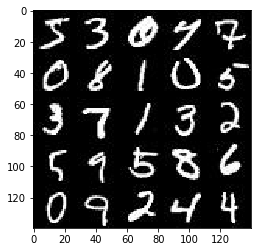

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

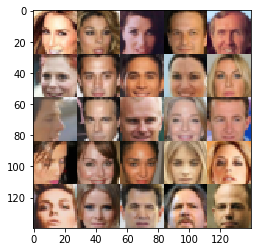

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse = (not is_train)):
        # First fully connected layer
        x = tf.reshape(tf.layers.dense(z, 7*7*448), (-1,7,7,448))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # conv2
        x = tf.layers.conv2d_transpose(x, 224, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # conv3
        x = tf.layers.conv2d_transpose(x, 112, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                    
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.3529
Epoch 1/2... Discriminator Loss: 23.4206... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 4.7535... Generator Loss: 0.2089
Epoch 1/2... Discriminator Loss: 3.8878... Generator Loss: 9.2800
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 3.7288
Epoch 1/2... Discriminator Loss: 17.4694... Generator Loss: 17.9625
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 1.6114
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 2.0250
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.7133
Epoch 1/2... Discriminator Loss: 0.2014... Generator Loss: 3.6315


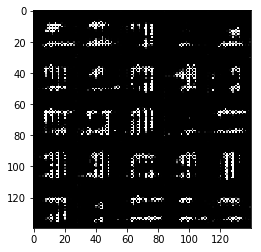

Epoch 1/2... Discriminator Loss: 0.2247... Generator Loss: 3.4436
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.4724
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 1.7988
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 3.9128
Epoch 1/2... Discriminator Loss: 0.2628... Generator Loss: 2.2989
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 2.5585
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.2937
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.5659


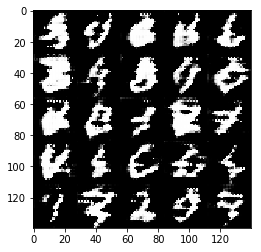

Epoch 1/2... Discriminator Loss: 0.2801... Generator Loss: 2.0184
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 0.5123


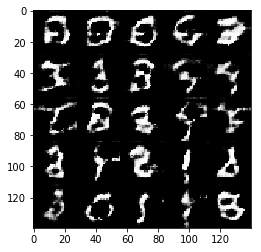

Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 1.0501
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 3.1948
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.8163
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 2.9614... Generator Loss: 0.0880
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.6247


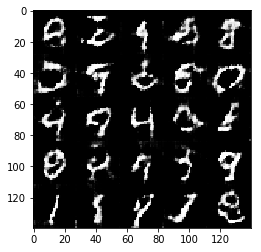

Epoch 1/2... Discriminator Loss: 2.0086... Generator Loss: 3.1037
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 2.3501
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.7231


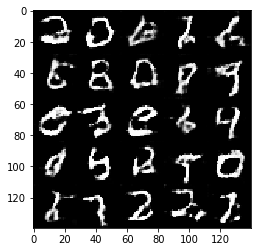

Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.5662
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 2.8958... Generator Loss: 0.1178
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.8280


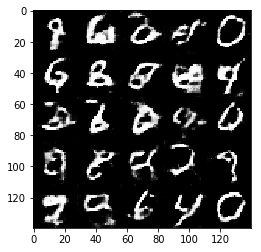

Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 2.8194
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0298
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.4401


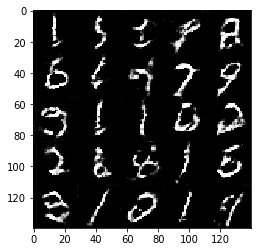

Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.3715
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 1.9990
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.9749
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 1.0191


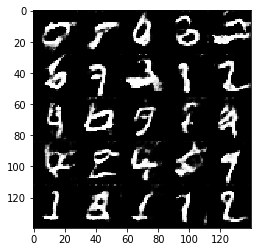

Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 2.1754
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.4772
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.6770


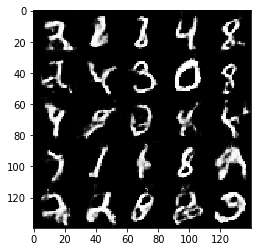

Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 2.0771... Generator Loss: 0.1981
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.9563... Generator Loss: 0.3300
Epoch 2/2... Discriminator Loss: 1.6771... Generator Loss: 4.0512
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.9967


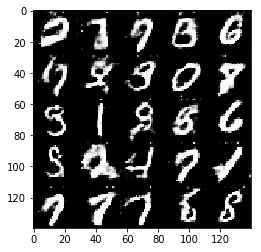

Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 0.1115... Generator Loss: 3.3845
Epoch 2/2... Discriminator Loss: 0.2929... Generator Loss: 6.1175
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 1.8289
Epoch 2/2... Discriminator Loss: 1.7223... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.8027
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.3316


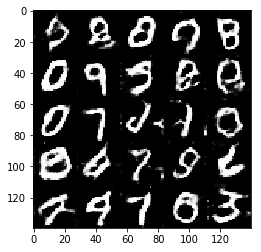

Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 2.3502
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.4747
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 2.8113
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.3889
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.9375


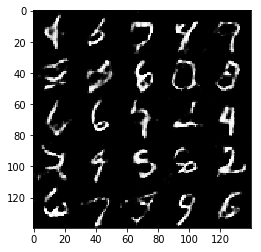

Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 2.3546
Epoch 2/2... Discriminator Loss: 2.2138... Generator Loss: 4.3772
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 2.0886
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 2.2509... Generator Loss: 0.2473
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 3.7437
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 2.2178


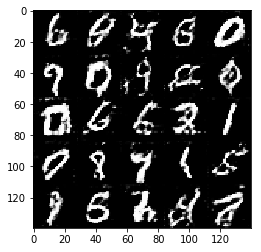

Epoch 2/2... Discriminator Loss: 0.1120... Generator Loss: 3.7622
Epoch 2/2... Discriminator Loss: 3.3250... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.6709
Epoch 2/2... Discriminator Loss: 1.8531... Generator Loss: 0.3378
Epoch 2/2... Discriminator Loss: 2.0706... Generator Loss: 0.3488
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 0.4391
Epoch 2/2... Discriminator Loss: 3.2599... Generator Loss: 6.7539
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.3497


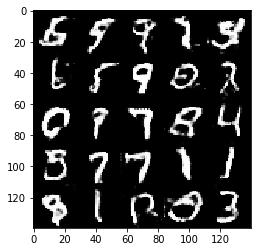

Epoch 2/2... Discriminator Loss: 2.7992... Generator Loss: 3.1516
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.4088
Epoch 2/2... Discriminator Loss: 1.6409... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 1.7037... Generator Loss: 0.4588
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 2.9471
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.9032
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.7903... Generator Loss: 0.6257


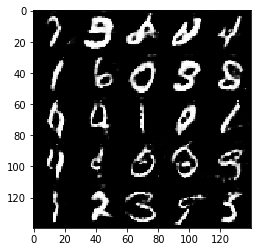

Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 2.9835
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 2.0092
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.2269
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8204


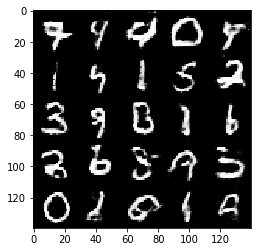

Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 4.0360
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 4.8354
Epoch 2/2... Discriminator Loss: 3.2991... Generator Loss: 0.1607
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 2.1548... Generator Loss: 0.2024


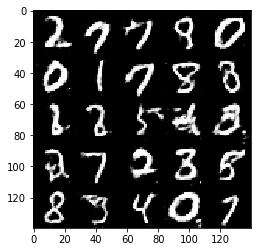

Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.7040
Epoch 2/2... Discriminator Loss: 2.0507... Generator Loss: 0.2908
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.7180... Generator Loss: 0.3541
Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.2672
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 2.3702
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.2503
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 2.0668
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.6871


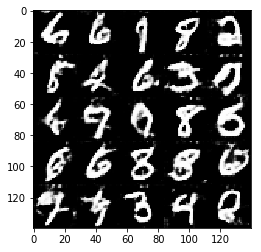

Epoch 2/2... Discriminator Loss: 1.5799... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.0073
Epoch 2/2... Discriminator Loss: 2.2538... Generator Loss: 0.2081
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.6778


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.02
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 3.3768... Generator Loss: 0.0558
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.6619
Epoch 1/1... Discriminator Loss: 2.5659... Generator Loss: 0.0984
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 5.6492
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 2.2687
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5573


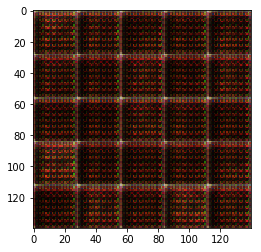

Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 2.1535
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.3404
Epoch 1/1... Discriminator Loss: 1.6478... Generator Loss: 0.3152
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.9086


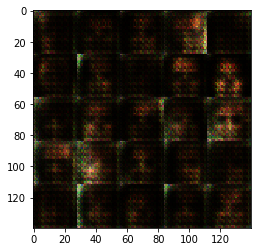

Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 1.7582... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.9629... Generator Loss: 0.2064
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.5776


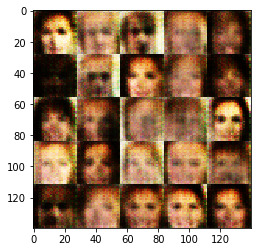

Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7586


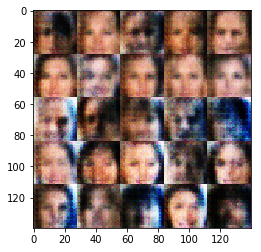

Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.2834
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8499


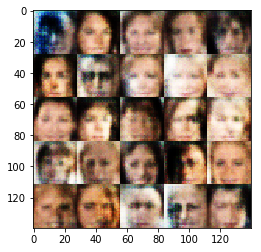

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.4387


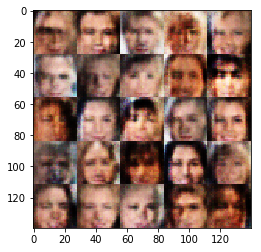

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.3958


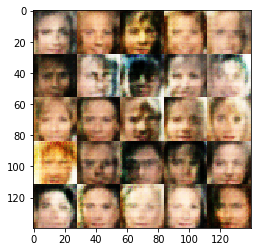

Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8374


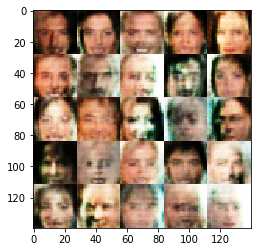

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.4270


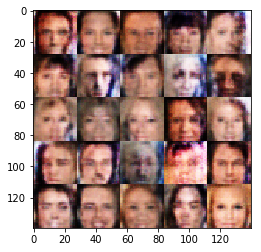

Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.5764


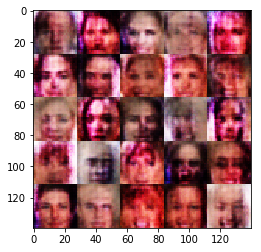

Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.8423... Generator Loss: 0.2272
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 0.8634


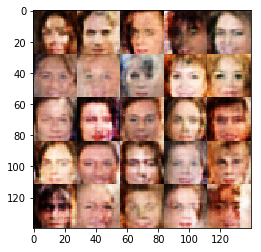

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7662


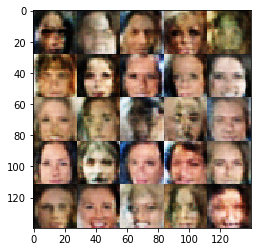

Epoch 1/1... Discriminator Loss: 1.9000... Generator Loss: 0.2044
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.6104


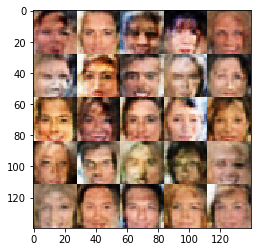

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 2.0548... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7031


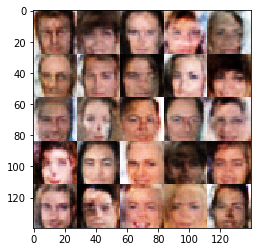

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.4525
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.4769


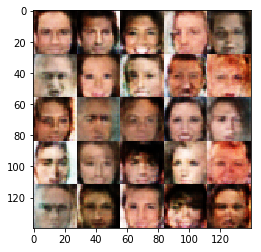

Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.2680
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.2595
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.4131
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9045


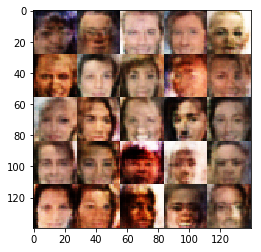

Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 2.0303... Generator Loss: 0.1812
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.9526... Generator Loss: 0.2056


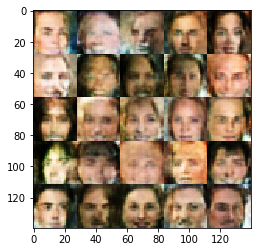

Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.9737


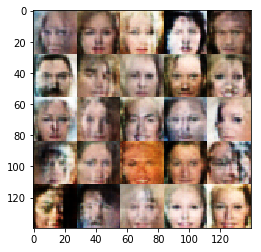

Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 0.9806


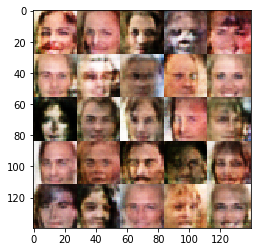

Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 2.0533
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.5631


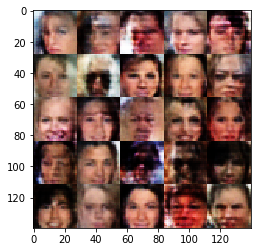

Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 2.3678
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8637


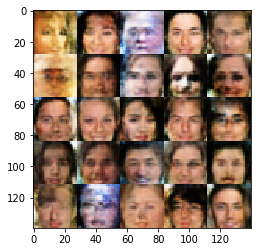

Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.2689
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.2958


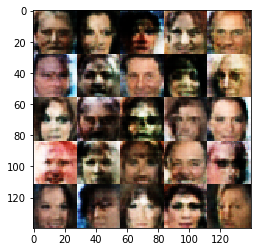

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.8845... Generator Loss: 0.2221


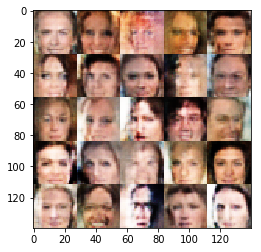

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.5856


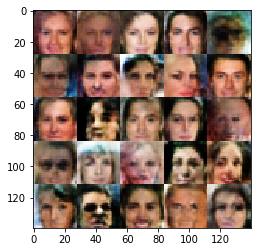

Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.2897
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.8970... Generator Loss: 0.2004
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.8849... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.7949


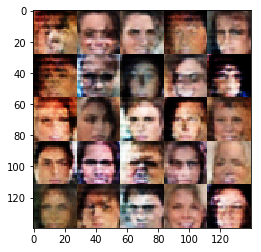

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 2.5114
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 1.8405... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1747


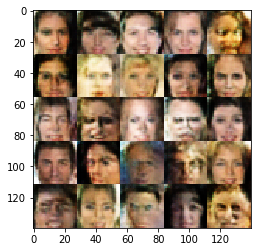

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.8931... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.2830
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.5334


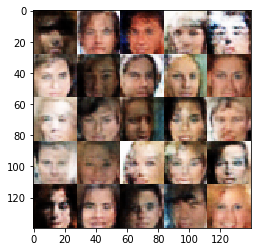

Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.4129


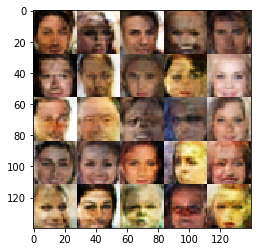

Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.7439


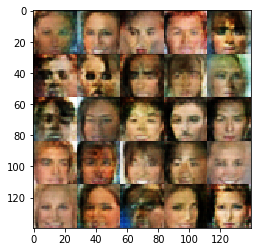

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.7606


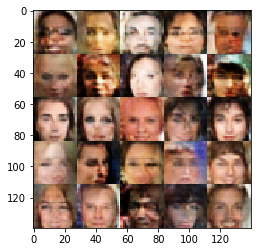

Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.2161
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7416


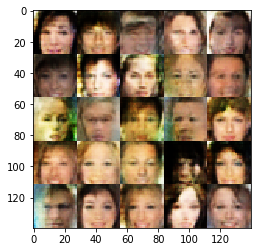

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.9552... Generator Loss: 0.1915
Epoch 1/1... Discriminator Loss: 1.7502... Generator Loss: 0.2696


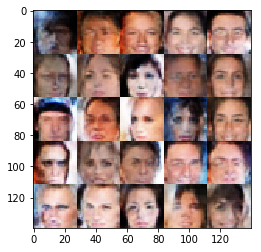

Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 0.2644
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.7175... Generator Loss: 0.2678
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.0858


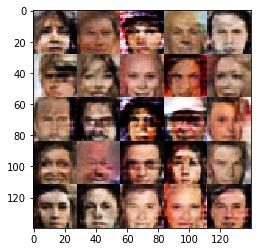

Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.2402
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 2.3756... Generator Loss: 0.1256
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4762


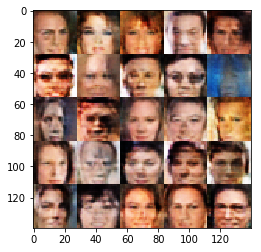

Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8887


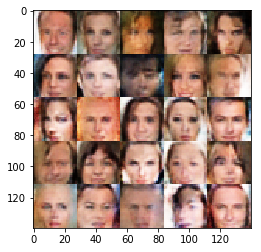

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.7683


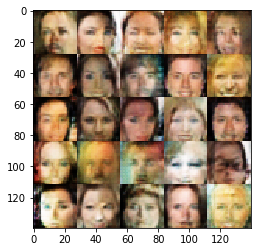

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 2.0607... Generator Loss: 0.1672
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.2479
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1252


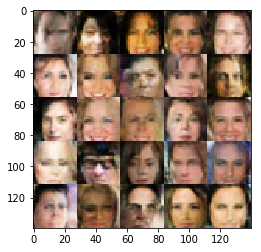

Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.4582


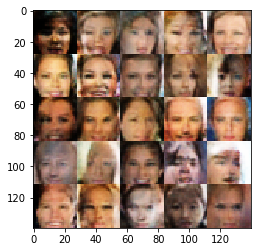

Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.2912


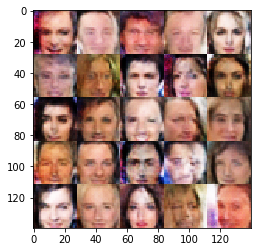

Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.0977


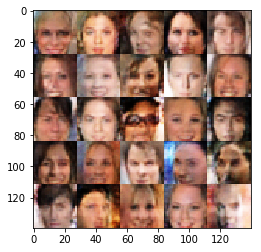

Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.4290


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.